# X-Unet V3_4

Training condition: 
- Load the pre-trained model from v3_3
- Fine-tune with 400 LUS, with 5-fold cross validation
    - **Freezing the bottleneck block (two conv layers with 1024 filters**
    - Learning rate 5e-6, trained with 100 epochs

In [1]:
%cd G:\My Drive\Lung_Segmentation

g:\My Drive\Lung_Segmentation


In [4]:
from DataPreprocessing import *
from ValidationAndPrediction import * 
from Model import *
import os
import re
import numpy as np
import pandas as pd
import natsort
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
from glob import glob
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold

In [5]:
tf.__version__

'2.6.0'

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4235077798761362034
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10095296512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2283982879934040555
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


Load the UNet model: 

In [7]:
width = 256
height = 256
channel = 3

# 1. Dealing with LUS - Data Preparation 



In [8]:
train_image_path = 'Lung_seg_data/NEW_TIF_IMG'
train_mask_path = 'Lung_seg_data/NEW_TIF_MASK'
train_images, train_masks = train_filepath_list(train_image_path, train_mask_path)
print('Number of train images: ', len(train_images))
print('Number of train masks: ', len(train_masks))

Number of train images:  200
Number of train masks:  200


Image shape:  (960, 128)
Mask shape:  (960, 128)


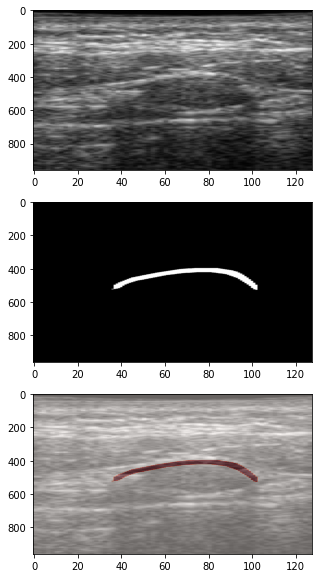

In [9]:
image_display(train_images, train_masks, 0)

In [11]:
gen_image_path = 'Lung_seg_data/NEW_CODES/newcode_gen_images'
gen_mask_path = 'Lung_seg_data/NEW_CODES/newcode_gen_masks'
gen_images, gen_masks = train_filepath_list(gen_image_path, gen_mask_path)
print('Number of train images: ', len(gen_images))
print('Number of train masks: ', len(gen_masks))
print(gen_images)

Number of train images:  200
Number of train masks:  200
['Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_5_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_10_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_15_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_20_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_25_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_30_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_35_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_40_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_45_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_50_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_105_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_110_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_115_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_120_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_p

Display one of the flipped images and masks as example

Image shape:  (960, 128, 3)
Mask shape:  (960, 128, 3)


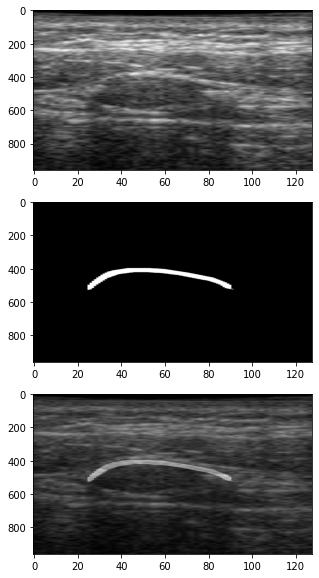

In [12]:
image_display(gen_images, gen_masks, 0)

**Creating a pandas Dataframe for all the filepaths of both original and generated dataset**
- use function `train_dataframe`

In [13]:
aug_images = train_images + gen_images
aug_masks = train_masks + gen_masks

US_df = train_dataframe(aug_images, aug_masks)
display(US_df)

,filename,mask
0,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_205.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_205.tif
1,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_545.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_545.tif
2,Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_...,Lung_seg_data/XPIEUS/gen_masks/mask_lung_pos2_...
3,Lung_seg_data/XPIEUS/gen_images/img_lung_pos3_...,Lung_seg_data/XPIEUS/gen_masks/mask_lung_pos3_...
4,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_125.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_125.tif
...,...,...
395,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_650.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_650.tif
396,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_545.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_545.tif
397,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_940.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_940.tif
398,Lung_seg_data/XPIEUS/gen_images/img_lung_pos3_...,Lung_seg_data/XPIEUS/gen_masks/mask_lung_pos3_...


**Use `ImageDataGenerator` for data augmentation**
- use function `train_generator`
- can generate images and masks at the same time using the same seed for the image and masks generators to ensure same transformation between corresponding images and masks 
- to be used in model training process

In [14]:
# Defining data augmentation dictionary 
train_generator_args = dict(rotation_range=0.15,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

# Redefine the input size of the images 
width = 256
height = 256
channel = 3

# To visualize the results of generator: set save_to_dir = "your path"
aug_img_dir = None
aug_mask_dir = None
aug_img_prefix = None
aug_mask_prefix = None
aug_format = None

# 2. Fine tune the model with LUS images
**Load the pre-trained model from v3_3 and use it for fine-tuning**

In [15]:
input_shape = (height, width, channel)

checkpoint_path = 'X_Unet/model_v3_3/pretrain_localGPU_xpie_unet_lungseg_v3_3.hdf5'

FTmodel = load_model(checkpoint_path, 
                    custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

FTmodel.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

**Freeze the layers in block 5 (Bottleneck block)**

In [16]:
for layer in FTmodel.layers:
  if layer.name in ["conv2d_8", "conv2d_9"]:
    layer.trainable = False

Display the layers status (trainable or non-trainable)

In [17]:
# Model groups layers into an object with training and inference features
layers = [(layer, layer.name, layer.trainable) for layer in FTmodel.layers]
FTmodel_df = pd.DataFrame(layers, columns=["Layer Type", "Layer Name", "Layer Trainable"])

display(FTmodel_df)

# now all layers are trainable: can set trainable=False to freeze layers 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_1,True
1,<keras.layers.convolutional.Conv2D object at 0...,conv2d,True
2,<keras.layers.convolutional.Conv2D object at 0...,conv2d_1,True
3,<keras.layers.pooling.MaxPooling2D object at 0...,max_pooling2d,True
4,<keras.layers.convolutional.Conv2D object at 0...,conv2d_2,True
5,<keras.layers.convolutional.Conv2D object at 0...,conv2d_3,True
6,<keras.layers.pooling.MaxPooling2D object at 0...,max_pooling2d_1,True
7,<keras.layers.convolutional.Conv2D object at 0...,conv2d_4,True
8,<keras.layers.convolutional.Conv2D object at 0...,conv2d_5,True
9,<keras.layers.pooling.MaxPooling2D object at 0...,max_pooling2d_2,True


In [18]:
FTmodel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

**Fine-tune the model with US images! (with KFold)**

Splitting the dataset: 80% for training, 20% for validation and testing

C:\Users\Wisely\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
C:\Users\Wisely\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


------------------------------------------------------------------------
Training for fold  1
Found 320 validated image filenames.
Found 320 validated image filenames.
Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: -0.3122 - iou: 0.1895 - dice_coef: 0.3122 - binary_accuracy: 0.9514Found 80 validated image filenames.
Found 80 validated image filenames.
16/16 [==============================] - 26s 846ms/step - loss: -0.3122 - iou: 0.1895 - dice_coef: 0.3122 - binary_accuracy: 0.9514 - val_loss: -0.4149 - val_iou: 0.2619 - val_dice_coef: 0.4149 - val_binary_accuracy: 0.9806

Epoch 00001: val_loss improved from inf to -0.41486, saving model to model_v3_4\1KF_finetune_localGPU_xpie_unet_lungseg_v3_3.hdf5
Epoch 2/100
16/16 [==============================] - 9s 597ms/step - loss: -0.5005 - iou: 0.3351 - dice_coef: 0.5005 - binary_accuracy: 0.9784 - val_loss: -0.5471 - val_iou: 0.3767 - val_dice_coef: 0.5471 - val_binary_accuracy: 0.9832

Epoch 00002: val_loss improved fr

C:\Users\Wisely\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Found 80 validated image filenames.
Found 80 validated image filenames.
------------------------------------------------------------------------
Training for fold  2
Found 320 validated image filenames.
Found 320 validated image filenames.
Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: -0.3286 - iou: 0.2011 - dice_coef: 0.3286 - binary_accuracy: 0.9590Found 80 validated image filenames.
Found 80 validated image filenames.
16/16 [==============================] - 10s 605ms/step - loss: -0.3286 - iou: 0.2011 - dice_coef: 0.3286 - binary_accuracy: 0.9590 - val_loss: -0.4439 - val_iou: 0.2856 - val_dice_coef: 0.4439 - val_binary_accuracy: 0.9802

Epoch 00001: val_loss improved from inf to -0.44385, saving model to model_v3_4\2KF_finetune_localGPU_xpie_unet_lungseg_v3_3.hdf5
Epoch 2/100
16/16 [==============================] - 9s 584ms/step - loss: -0.5176 - iou: 0.3506 - dice_coef: 0.5176 - binary_accuracy: 0.9793 - val_loss: -0.5682 - val_iou: 0.3970 - val_dice_coef:

,Accuracy,Loss,Dice coef,IOU
0,0.991786,-0.814007,0.814007,0.686403
1,0.991398,-0.795184,0.795184,0.660226
2,0.991429,-0.802627,0.802627,0.670416
3,0.991027,-0.780648,0.780648,0.640374
4,0.991585,-0.803683,0.803683,0.671973


Evaluation scores from 5 Fold fine-tuning model:
Accuracies :  [0.9917856454849243, 0.9913982152938843, 0.991428554058075, 0.9910266995429993, 0.9915847778320312]
Losses :  [-0.8140066862106323, -0.7951837182044983, -0.8026267886161804, -0.7806482315063477, -0.803682804107666]
Dice coefficients :  [0.8140066862106323, 0.7951837182044983, 0.8026267290115356, 0.7806482315063477, 0.803682804107666]
IOUs :  [0.6864028573036194, 0.6602264642715454, 0.6704161763191223, 0.6403738260269165, 0.6719726324081421]

Average accuracy :  0.9914447784423828
Average loss :  -0.799229645729065
Average dice coefficient :  0.7992296338081359
Average IOU :  0.6658783912658691

SD of accuracy :  0.000250204513687083
SD of loss :  0.01105776296349774
SD of dice coefficient :  0.011057759301199892
SD of iou :  0.015240814290592347


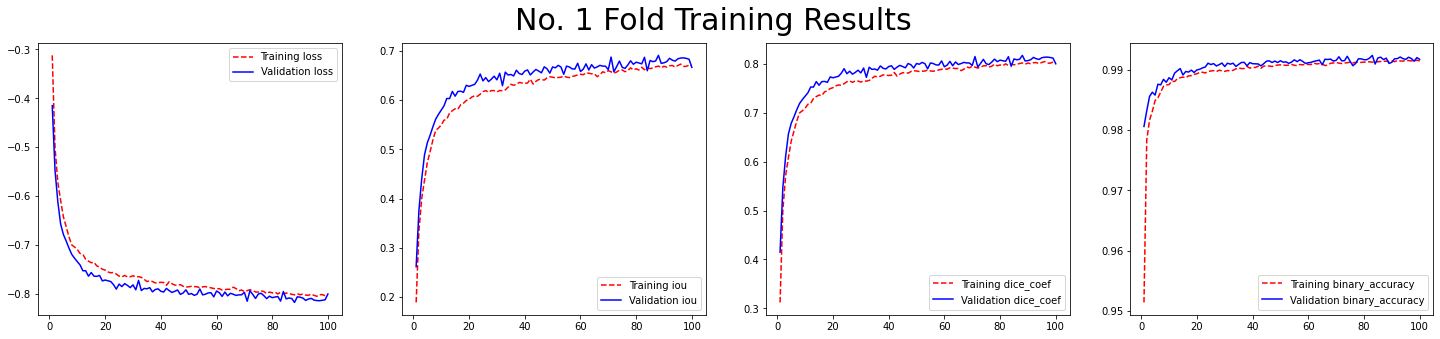

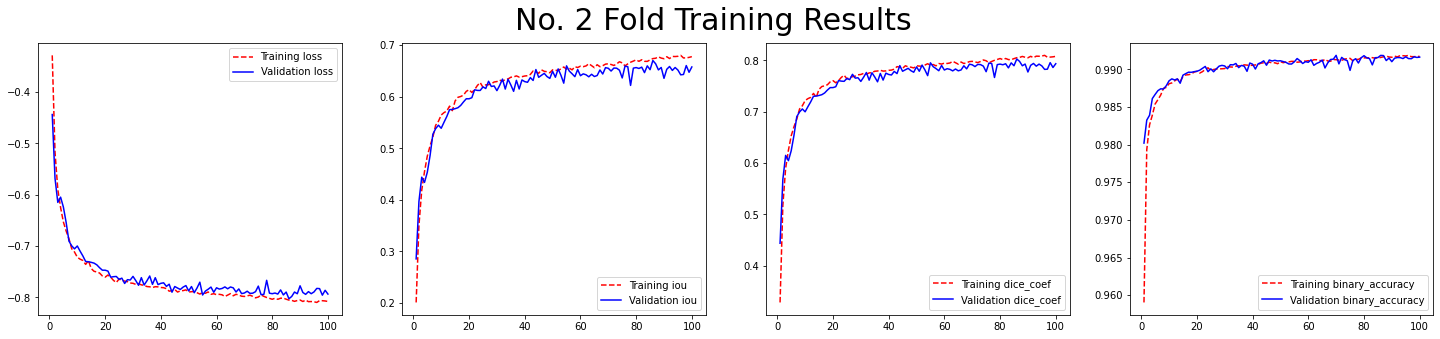

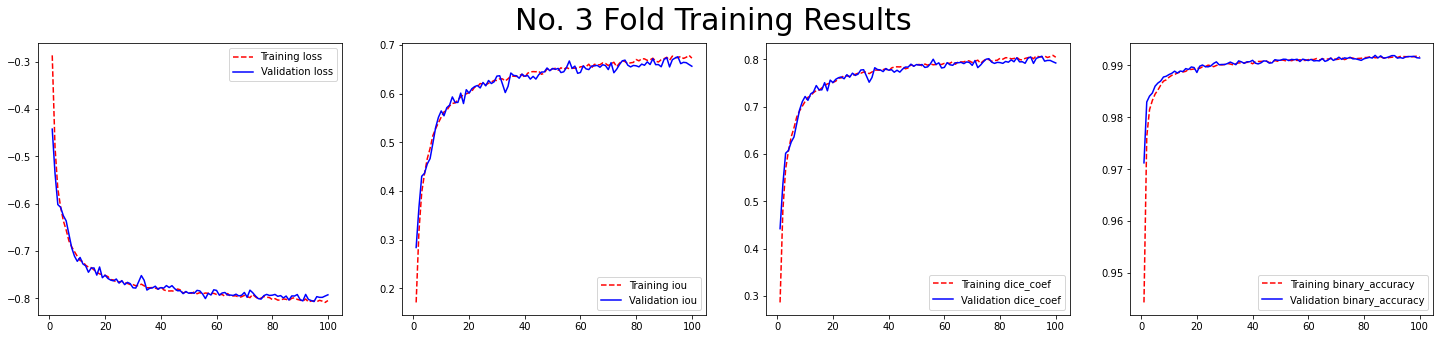

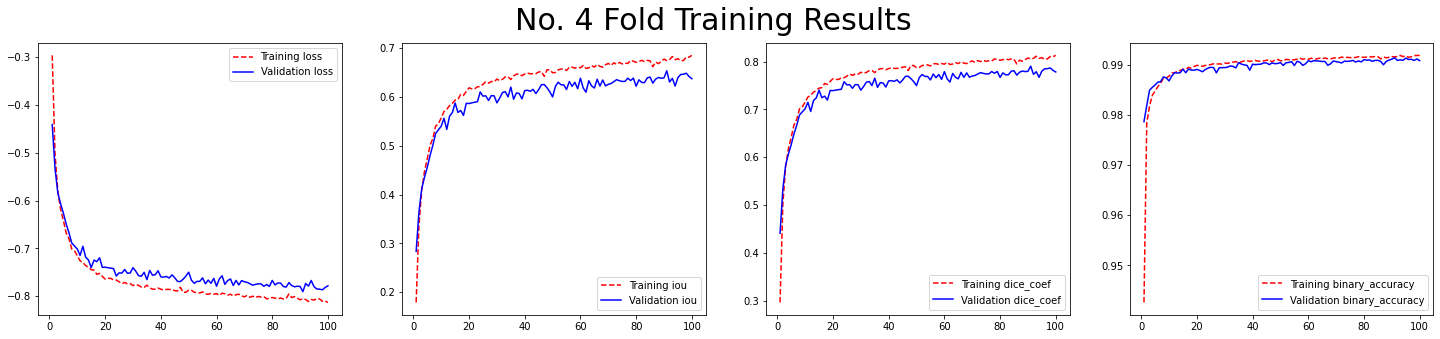

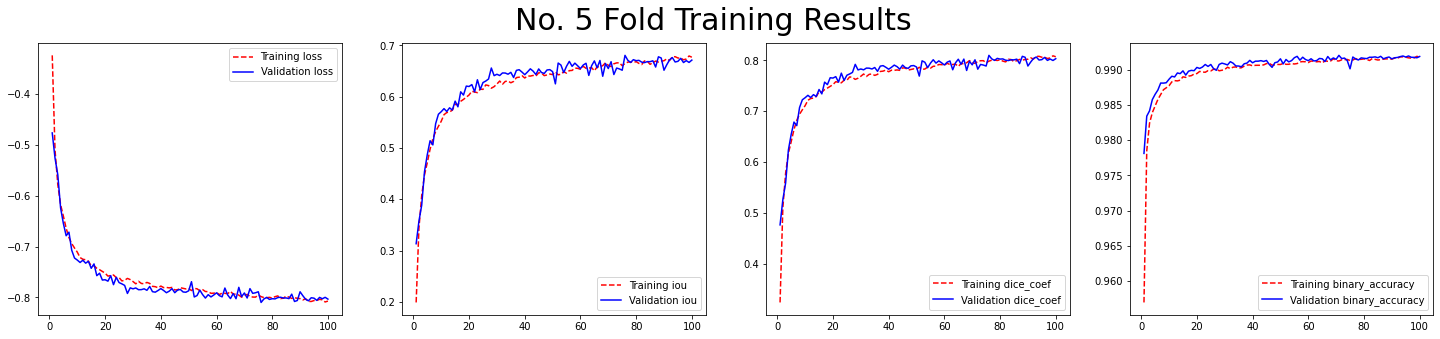

In [19]:
kf_histories = []
kf_losses = []
kf_accuracies = []
kf_dicecoefs = []
kf_ious = []

# same batch size and epochs
epochs = 100
batch_size = 20

# added KFold in here:
kf = KFold(n_splits = 5, shuffle=True)

for k, (train_index, test_index) in enumerate(kf.split(US_df)):
    kf_train_df = US_df.iloc[train_index]
    kf_test_df = US_df.iloc[test_index]
    
    kf_train_gen = train_generator(kf_train_df, batch_size, 
                                None, 
                                train_generator_args,
                                None, None, None, None, None,
                                (height, width))

    kf_test_gen = train_generator(kf_test_df, batch_size,
                               None, 
                               dict(),
                               None, None, None, None, None, 
                               (height, width))
    
    FTmodel = load_model(checkpoint_path, 
                    custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
    
    for layer in FTmodel.layers:
      if layer.name in ["conv2d_8", "conv2d_9"]:
        layer.trainable = False

    FTmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])
    
    kf_checkpoint_path = 'X_Unet/model_v3_4/' + str(k+1) + 'KF_finetune_localGPU_xpie_unet_lungseg_v3_4.hdf5'

    kf_model_checkpoint = ModelCheckpoint(kf_checkpoint_path,
                                         verbose=1, 
                                         monitor='val_loss',
                                         save_best_only=True)

    kf_csvlogger = CSVLogger(filename='X_Unet/model_v3_4/'+ str(k+1) +'KF_finetune_loclGPU_xpie_traininglog_v3_4.csv', separator=",", append=True)
    
    kf_callbacks_list = [kf_model_checkpoint, kf_csvlogger]
    
    print('------------------------------------------------------------------------')
    print('Training for fold ', k+1)
    
    kf_history = FTmodel.fit_generator(kf_train_gen, 
                                       steps_per_epoch=len(kf_train_df)//batch_size,
                                       epochs=epochs,
                                       callbacks=kf_callbacks_list,
                                       validation_data = kf_test_gen, 
                                       validation_steps = len(kf_test_df)//batch_size,
                                       verbose=1)
    
    KFmodel = load_model(kf_checkpoint_path, 
                       custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
    KFmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                    metrics=[iou, dice_coef, 'binary_accuracy'])
    
    
    # another generator for evaluate_generator 
    kf_evaluate_gen = train_generator(kf_test_df, batch_size,
                                   None,
                                   dict(),
                                   None, None, None, None, None,
                                   (height, width))
    
    kf_results = KFmodel.evaluate_generator(kf_evaluate_gen, 
                                      steps=len(kf_test_df)//batch_size)
    kf_results = dict(zip(KFmodel.metrics_names,kf_results))
    
    kf_histories.append(kf_history)
    kf_accuracies.append(kf_results['binary_accuracy'])
    kf_losses.append(kf_results['loss'])
    kf_dicecoefs.append(kf_results['dice_coef'])
    kf_ious.append(kf_results['iou'])


plot_histories(kf_histories)

kf_results_df = pd.DataFrame(data={'Accuracy': kf_accuracies, 'Loss': kf_losses, 'Dice coef': kf_dicecoefs, 'IOU': kf_ious},
                             dtype = np.float64)
kf_results_df.to_csv(path_or_buf='X_Unet/model_v3_4/KF_finetune_results.csv')
display(kf_results_df)

# Print all the evaluation scores: 
print('Evaluation scores from 5 Fold fine-tuning model:')
print('Accuracies : ', kf_accuracies)
print('Losses : ', kf_losses)
print('Dice coefficients : ', kf_dicecoefs)
print('IOUs : ', kf_ious)

print('')

print('Average accuracy : ', np.mean(np.array(kf_accuracies)))
print('Average loss : ', np.mean(np.array(kf_losses)))
print('Average dice coefficient : ', np.mean(np.array(kf_dicecoefs)))
print('Average IOU : ', np.mean(np.array(kf_ious)))

print('')

print('SD of accuracy : ', np.std(np.array(kf_accuracies)))
print('SD of loss : ', np.std(np.array(kf_losses)))
print('SD of dice coefficient : ', np.std(np.array(kf_dicecoefs)))
print('SD of iou : ', np.std(np.array(kf_ious)))